Step 1: Data Analysis and Preprocessing

In [2]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('D:\\Machine Learning Dataset\\spam.csv', encoding='latin-1')
# Clean the dataset - keep only relevant columns
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")
print(f"Spam percentage: {df['label'].value_counts()['spam']/len(df)*100:.2f}%")

Dataset shape: (5572, 2)
Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
Spam percentage: 13.41%


Step 2: Text Preprocessing Function

In [3]:
def preprocess_text(text):
    """
    Clean and preprocess text data
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Convert labels to binary (spam=1, ham=0)
df['label_binary'] = df['label'].map({'spam': 1, 'ham': 0})

print("Sample preprocessed texts:")
print(df[['text', 'cleaned_text']].head())

Sample preprocessed texts:
                                                text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                        cleaned_text  
0  go until jurong point crazy available only in ...  
1                            ok lar joking wif u oni  
2  free entry in a wkly comp to win fa cup final ...  
3        u dun say so early hor u c already then say  
4  nah i dont think he goes to usf he lives aroun...  


Step 3: Feature Extraction using TF-IDF

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['label_binary'], 
    test_size=0.2, random_state=42, stratify=df['label_binary']
)

# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit vocabulary size
    stop_words='english',
    ngram_range=(1, 2)  # Use unigrams and bigrams
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Testing features shape: {X_test_tfidf.shape}")

Training features shape: (4457, 5000)
Testing features shape: (1115, 5000)


Step 4: Model Training and Evaluation

Accuracy: 0.9668

Classification Report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.76      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



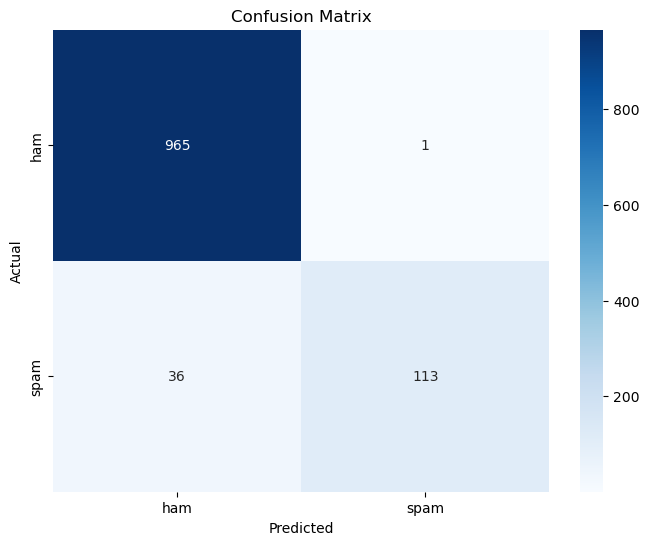

In [6]:
# Train Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Step 5: Model Interpretation

In [7]:
# Get feature importance (words most associated with spam)
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

# Create a DataFrame of feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort by absolute coefficient value (importance)
feature_importance['abs_coef'] = np.abs(feature_importance['coefficient'])
top_spam_words = feature_importance.nlargest(10, 'abs_coef')

print("Top words associated with spam:")
print(top_spam_words[['feature', 'coefficient']])

Top words associated with spam:
      feature  coefficient
4584      txt     4.976339
660     claim     3.812431
2533   mobile     3.404047
1314     free     3.279014
3601    reply     3.269757
4420     text     3.216486
4286     stop     2.869793
3901  service     2.801768
3353    prize     2.795310
4881      won     2.720405


Step 6: Testing on New/Unseen Data

In [8]:
def predict_spam(email_text, model, vectorizer, threshold=0.5):
    """
    Predict if an email is spam
    """
    # Preprocess the text
    cleaned_text = preprocess_text(email_text)
    
    # Transform using TF-IDF
    text_tfidf = vectorizer.transform([cleaned_text])
    
    # Get prediction probability
    spam_probability = model.predict_proba(text_tfidf)[0, 1]
    
    # Make prediction based on threshold
    prediction = "spam" if spam_probability > threshold else "ham"
    
    return prediction, spam_probability

# Test with some example emails
test_emails = [
    "Congratulations! You've won a $1000 prize! Call now to claim.",
    "Hey, are we still meeting for lunch tomorrow?",
    "Free entry to win a luxury car! Text YES to claim your prize.",
    "Hi mom, just checking in to see how you're doing.",
    "URGENT: Your account has been compromised. Click here to secure it."
]

print("\nTesting on new emails:")
print("=" * 50)
for i, email in enumerate(test_emails, 1):
    prediction, probability = predict_spam(email, model, tfidf_vectorizer)
    print(f"Email {i}: {prediction.upper()} (confidence: {probability:.4f})")
    print(f"Text: {email[:100]}...")
    print("-" * 30)


Testing on new emails:
Email 1: SPAM (confidence: 0.7596)
Text: Congratulations! You've won a $1000 prize! Call now to claim....
------------------------------
Email 2: HAM (confidence: 0.0250)
Text: Hey, are we still meeting for lunch tomorrow?...
------------------------------
Email 3: SPAM (confidence: 0.8488)
Text: Free entry to win a luxury car! Text YES to claim your prize....
------------------------------
Email 4: HAM (confidence: 0.0387)
Text: Hi mom, just checking in to see how you're doing....
------------------------------
Email 5: HAM (confidence: 0.3738)
Text: URGENT: Your account has been compromised. Click here to secure it....
------------------------------


Step 7: Model Optimization (Optional)

In [10]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Use a smaller subset for faster grid search
X_train_small = X_train_tfidf[:1000]  # Use first 1000 samples for speed
y_train_small = y_train[:1000]

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train_small, y_train_small)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Train final model with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_tfidf, y_train)

# Evaluate optimized model
y_pred_optimized = best_model.predict(X_test_tfidf)
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized model accuracy: {optimized_accuracy:.4f}")

Best parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.718125449393055
Optimized model accuracy: 0.9767
